In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
# !pip install matplotlib_scalebar --upgrade

In [3]:
import os
import warnings

import geopandas as gpd
import nivapy3 as nivapy
import pandas as pd
import teotil3 as teo
import utils

warnings.simplefilter("ignore")

In [4]:
eng = nivapy.da.connect_postgis()

Connection successful.


# Notebook 02: Aggregate data to reporting units

This notebook aggregates the vassdragsområde-level from notebook 01 to the regions included in the report. It also creates some of the national maps used in the report.

In [5]:
st_yr = 1990
end_yr = 2023  # Assumed to be report year
agri_loss_model = "risk"

## 1. Create results tables for report regions

In [6]:
# Build result folders
data_fold = f"../report_data/{end_yr}/tables"
plot_fold = f"../report_data/{end_yr}/plots"
for dir_path in [data_fold, plot_fold]:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

# Read vassom data (from notebook 01)
csv_path = f"../report_data/{end_yr}/teotil2-3_vassom_npc_tonnes_{st_yr}-{end_yr}_agri-{agri_loss_model}-loss_bias-corrected.csv"
df = pd.read_csv(csv_path)

# Aggregate to regions
result_dict = {}
for par in ["n", "p", "c"]:
    par_reg_dict = utils.aggregate_regions(df, par, data_fold)
    result_dict[par] = par_reg_dict

    # Create plots
    for reg, reg_df in par_reg_dict.items():
        utils.make_plot(reg_df, reg, par, out_fold=plot_fold)

## 2. Map data

### 2.1. Site maps

875 aquaculture sites in 2023.
152 industry sites in 2023.
2623 large wastewater sites in 2023.


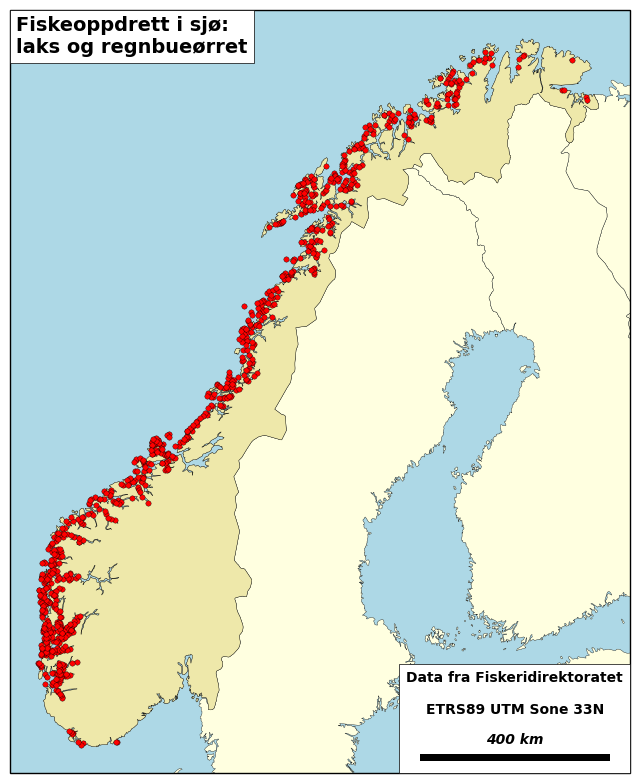

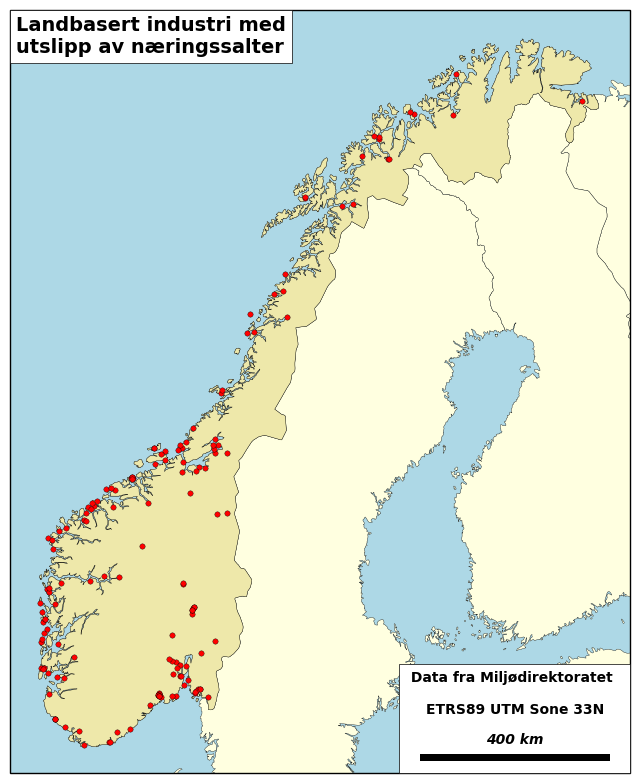

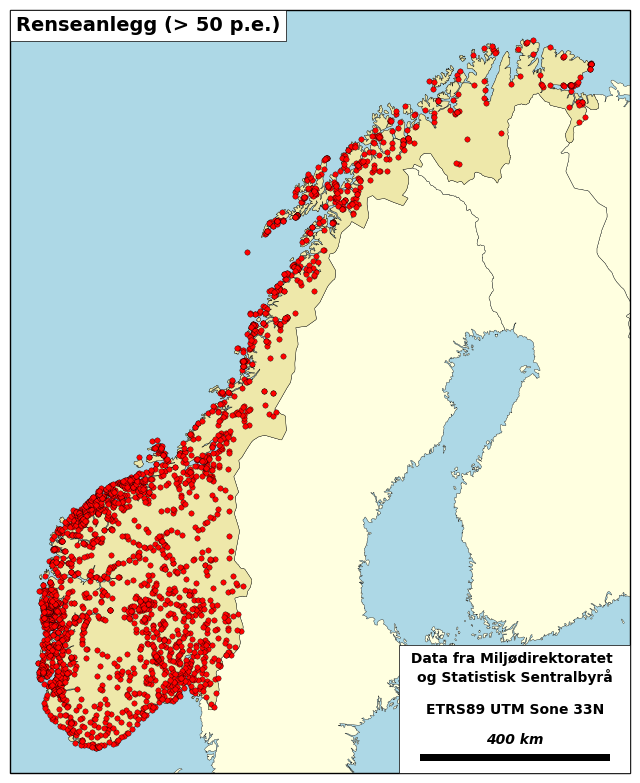

In [7]:
# Point data => map annotations
sector_dict = {
    "aquaculture": {
        "title": "Fiskeoppdrett i sjø:\nlaks og regnbueørret",
        "notes": "Data fra Fiskeridirektoratet\n\nETRS89 UTM Sone 33N\n\n\n",
    },
    "industry": {
        "title": "Landbasert industri med\nutslipp av næringssalter",
        "notes": " Data fra Miljødirektoratet  \n\nETRS89 UTM Sone 33N\n\n\n",
    },
    "large wastewater": {
        "title": "Renseanlegg (> 50 p.e.)",
        "notes": " Data fra Miljødirektoratet  \nog Statistisk Sentralbyrå\n\nETRS89 UTM Sone 33N\n\n\n",
    },
}
for sector, map_data in sector_dict.items():
    # Get all unique points for sector
    pt_df = teo.io.get_raw_annual_point_data(
        eng,
        end_yr,
        sector,
        par_list=[
            "totn_kg",
            "totp_kg",
            "toc_kg",
        ],
    ).dropna(subset=["TOC_kg", "TOTN_kg", "TOTP_kg"], how="all")

    assert pt_df["site_id"].is_unique

    pt_gdf = gpd.GeoDataFrame(
        pt_df,
        geometry=gpd.points_from_xy(
            pt_df.outlet_x_utm33, pt_df.outlet_y_utm33, crs="epsg:25833"
        ),
    )
    print(f"{len(pt_gdf)} {sector} sites in {end_yr}.")
    
    # Make map
    title = map_data["title"]
    notes = map_data["notes"]
    png_path = os.path.join(plot_fold, f"{sector.replace(' ', '-')}.png")
    utils.make_point_map(pt_gdf, title, notes, png_path=png_path)

### 2.2. Regional summary maps

#### 2.2.1. Vannregioner

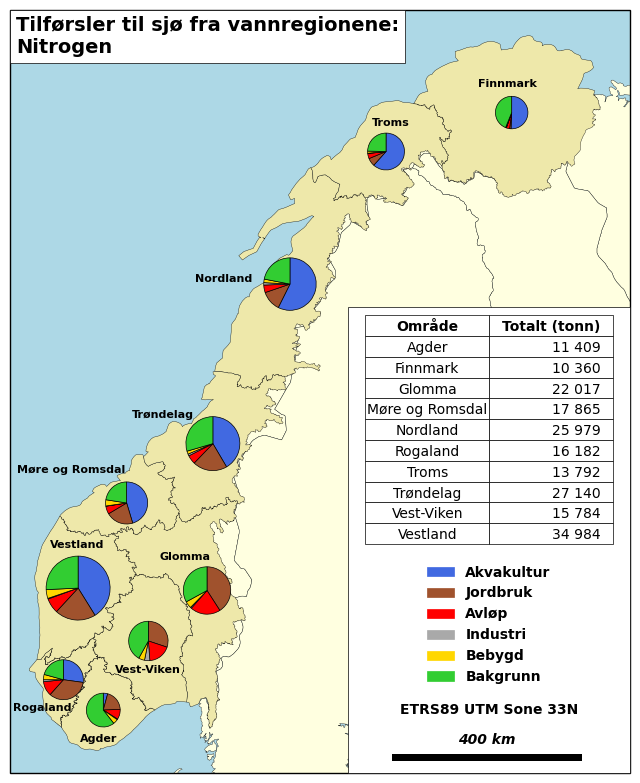

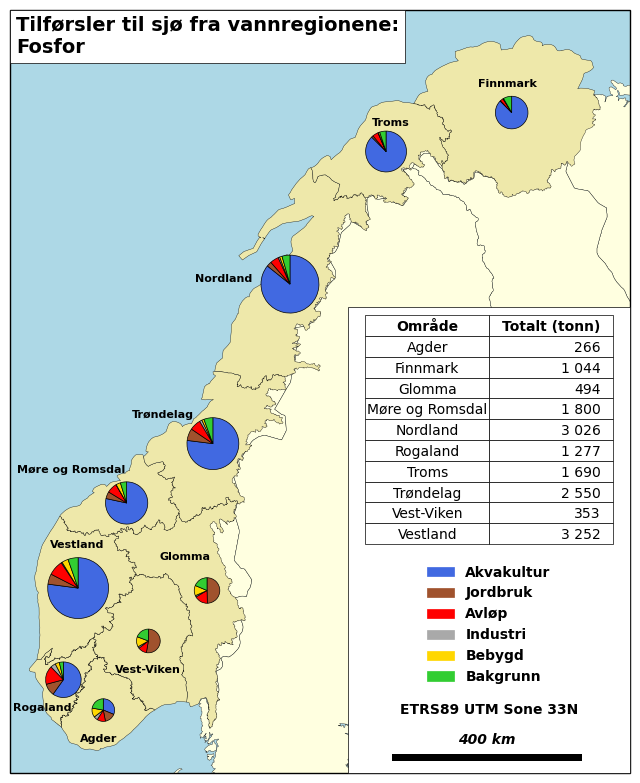

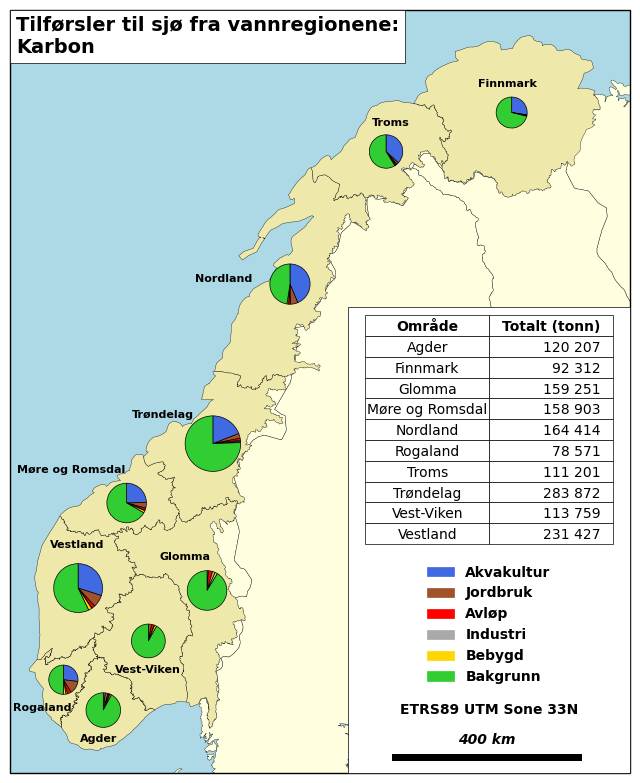

In [8]:
# Dict with label offsets relative to pie centres
# Adjust each year as necessary
vannreg_dict = {
    "Glomma": (-100000, 70000),
    "Vest-Viken": (-70000, -60000),
    "Agder": (-50000, -60000),
    "Rogaland": (-105000, -60000),
    "Vestland": (-60000, 90000),
    "Møre og Romsdal": (-230000, 70000),
    "Trøndelag": (-170000, 60000),
    "Nordland": (-200000, 10000),
    "Troms": (-30000, 60000),
    "Finnmark": (-70000, 60000),
}

# Dict giving full names for parameters and scale factors for sizing pie charts.
# Adjust as needed. Bigger values mean bigger pie charts
par_dict = {"n": ("Nitrogen", 2), "p": ("Fosfor", 20), "c": ("Karbon", 0.2)}

# Loop over pars
for par, (name, pie_scale_factor) in par_dict.items():
    gdf = gpd.read_file(r"../gis/vannregioner.shp").query("Vannreg != 'Til Sverige'")
    df_list = []
    for reg in vannreg_dict:
        # Get data for each region
        fpath = os.path.join(data_fold, f"{reg}_{par}.csv")
        df = pd.read_csv(fpath)
        df = df.query("År == @end_yr")
        df["Vannreg"] = reg
        df.drop(["År", "Menneskeskapt"], axis="columns", inplace=True)
        df_list.append(df)

    # Combine
    df = pd.concat(df_list, axis="rows")
    gdf = gdf.merge(df, how="left", on="Vannreg")
    gdf.rename(columns={"Vannreg": "Område"}, inplace=True)

    # Make map
    title = f"Tilførsler til sjø fra vannregionene:\n{name}"
    png_path = os.path.join(plot_fold, f"vannregion_{par}.png")
    utils.make_pie_map(
        gdf, title, vannreg_dict, pie_scale_factor=pie_scale_factor, png_path=png_path
    )

#### 2.2.2. Forvaltningsplanområder

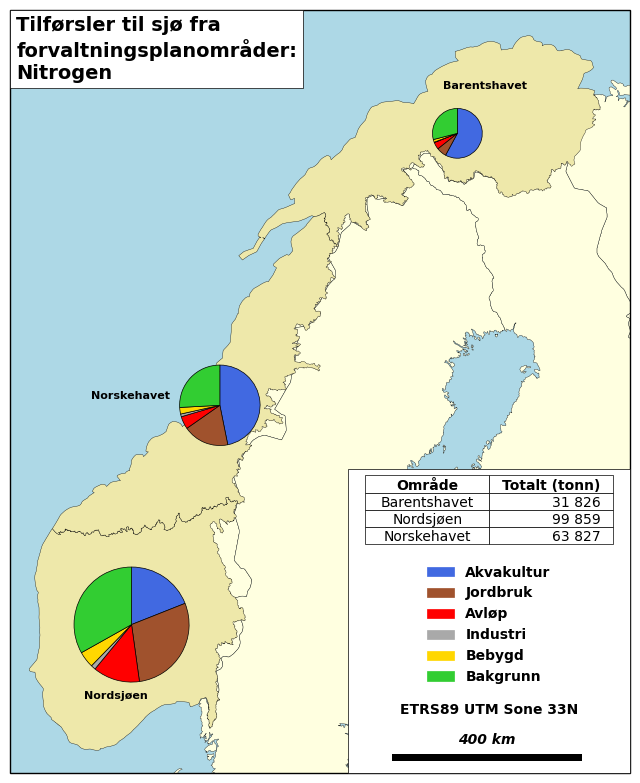

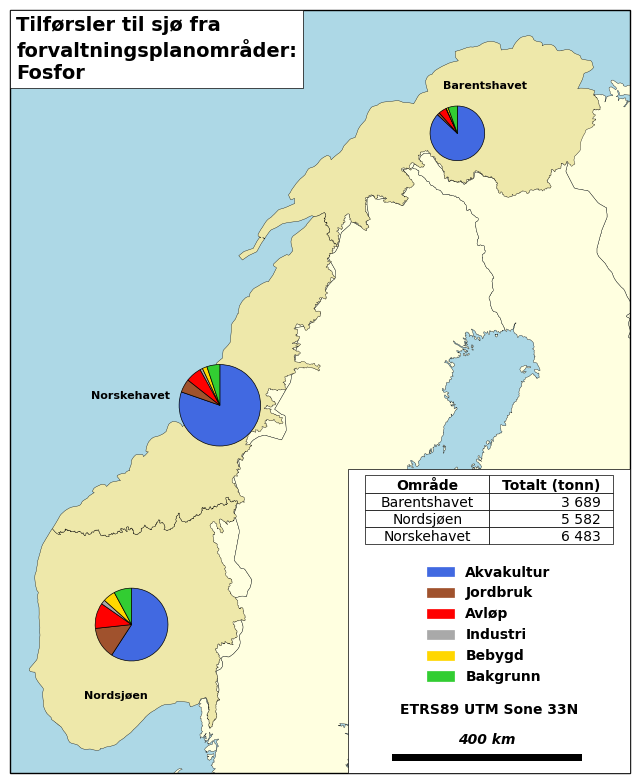

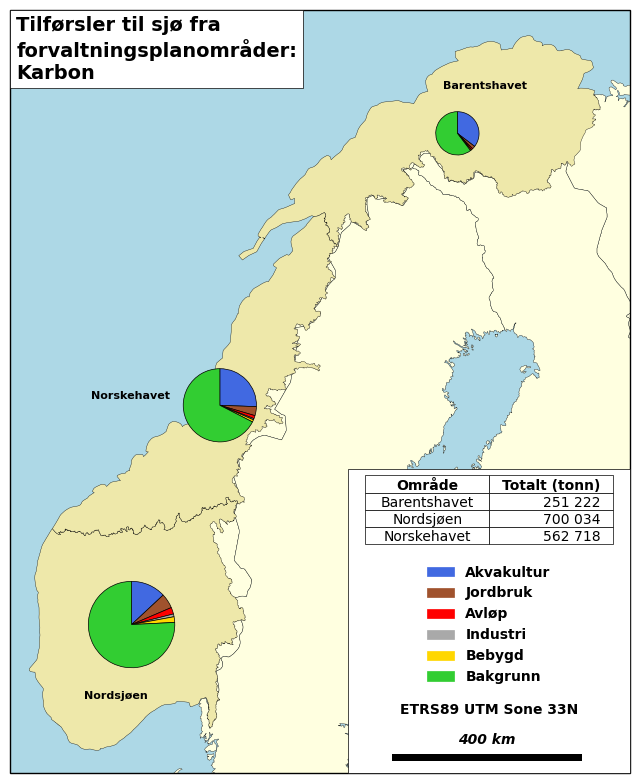

In [9]:
# Dict with label offsets relative to pie centres
# Adjust each year as necessary
fvpo_dict = {
    "Barentshavet": (-30000, 100000),
    "Nordsjøen": (-100000, -150000),
    "Norskehavet": (-270000, 20000),
}

# Dict giving full names for parameters and scale factors for sizing pie charts.
# Adjust as needed. Bigger values mean bigger pie charts
par_dict = {"n": ("Nitrogen", 1.5), "p": ("Fosfor", 15), "c": ("Karbon", 0.15)}

# Loop over pars
for par, (name, pie_scale_factor) in par_dict.items():
    gdf = gpd.read_file(r"../gis/forvaltningsplanomrader.shp").query(
        "Hav != 'Til Sverige'"
    )
    df_list = []
    for reg in fvpo_dict:
        # Get data for each region
        fpath = os.path.join(data_fold, f"{reg}_{par}.csv")
        df = pd.read_csv(fpath)
        df = df.query("År == @end_yr")
        df["Hav"] = reg
        df.drop(["År", "Menneskeskapt"], axis="columns", inplace=True)
        df_list.append(df)

    # Combine
    df = pd.concat(df_list, axis="rows")
    gdf = gdf.merge(df, how="left", on="Hav")
    gdf.rename(columns={"Hav": "Område"}, inplace=True)

    # Make map
    title = f"Tilførsler til sjø fra\nforvaltningsplanområder:\n{name}"
    png_path = os.path.join(plot_fold, f"forvaltom_{par}.png")
    utils.make_pie_map(
        gdf, title, fvpo_dict, pie_scale_factor=pie_scale_factor, png_path=png_path
    )